# Grid sampler feature request or issue

- https://github.com/pytorch/pytorch/issues/100526

In [1]:
import torch
import torchvision
torchvision.disable_beta_transforms_warning()


from torchvision.transforms.v2.functional._geometry import _get_inverse_affine_matrix, _compute_affine_output_size, _apply_grid_transform

In [2]:
def _affine_grid(
    theta: torch.Tensor,
    w: int,
    h: int,
    ow: int,
    oh: int,
) -> torch.Tensor:
    # https://github.com/pytorch/pytorch/blob/74b65c32be68b15dc7c9e8bb62459efbfbde33d8/aten/src/ATen/native/
    # AffineGridGenerator.cpp#L18
    # Difference with AffineGridGenerator is that:
    # 1) we normalize grid values after applying theta
    # 2) we can normalize by other image size, such that it covers "extend" option like in PIL.Image.rotate
    dtype = theta.dtype
    device = theta.device

    base_grid = torch.empty(1, oh, ow, 3, dtype=dtype, device=device)
    x_grid = torch.linspace((1.0 - ow) * 0.5, (ow - 1.0) * 0.5, steps=ow, device=device)
    base_grid[..., 0].copy_(x_grid)
    y_grid = torch.linspace((1.0 - oh) * 0.5, (oh - 1.0) * 0.5, steps=oh, device=device).unsqueeze_(-1)
    base_grid[..., 1].copy_(y_grid)
    base_grid[..., 2].fill_(1)

    rescaled_theta = theta.transpose(1, 2).div_(torch.tensor([0.5 * w, 0.5 * h], dtype=dtype, device=device))
    output_grid = base_grid.view(1, oh * ow, 3).bmm(rescaled_theta)
    return output_grid.view(1, oh, ow, 2)

In [3]:
image = torchvision.io.read_image("../dog.jpg")

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline


In [5]:
angle = 45
height, width = image.shape[-2:]
center = [0.0, 0.0]

matrix = _get_inverse_affine_matrix(center, -angle, [0.34 * height, -0.23 * width], 1.3, [0.0, 0.0])
theta = torch.tensor(matrix, dtype=torch.float32).reshape(1, 2, 3)


In [6]:
ow, oh = width, height
grid = _affine_grid(theta.clone(), w=width, h=height, ow=ow, oh=oh)
output = _apply_grid_transform(image[None, ...], grid, "bilinear", 0)
output = output[0]

In [7]:
ow, oh = 2 * width, 2 * height
grid = _affine_grid(theta.clone(), w=width, h=height, ow=ow, oh=oh)
output2 = _apply_grid_transform(image[None, ...], grid, "bilinear", 0)
output2 = output2[0]

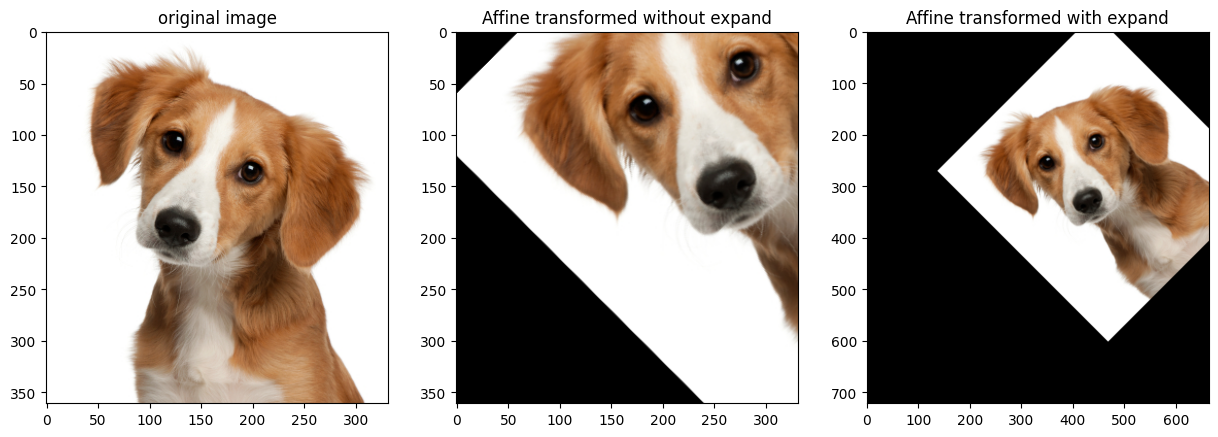

In [8]:
plt.figure(figsize=(15, 8))
plt.subplot(131)
plt.title("original image")
plt.imshow(image.permute(1, 2, 0))
plt.subplot(132)
plt.title("Affine transformed without expand")
plt.imshow(output.permute(1, 2, 0))
plt.subplot(133)
plt.title("Affine transformed with expand")
plt.imshow(output2.permute(1, 2, 0))

In [45]:
from typing import List


def _perspective_grid(
    coeffs: List[float], 
    w: int, h: int, 
    ow: int, oh: int, 
    dtype: torch.dtype, 
    device: torch.device,
    center = None,
) -> torch.Tensor:
    # https://github.com/python-pillow/Pillow/blob/4634eafe3c695a014267eefdce830b4a825beed7/
    # src/libImaging/Geometry.c#L394

    #
    # x_out = (coeffs[0] * x + coeffs[1] * y + coeffs[2]) / (coeffs[6] * x + coeffs[7] * y + 1)
    # y_out = (coeffs[3] * x + coeffs[4] * y + coeffs[5]) / (coeffs[6] * x + coeffs[7] * y + 1)
    #
    theta1 = torch.tensor(
        [[[coeffs[0], coeffs[1], coeffs[2]], [coeffs[3], coeffs[4], coeffs[5]]]], dtype=dtype, device=device
    )
    theta2 = torch.tensor([[[coeffs[6], coeffs[7], 1.0], [coeffs[6], coeffs[7], 1.0]]], dtype=dtype, device=device)

    d = 0.5
    base_grid = torch.empty(1, oh, ow, 3, dtype=dtype, device=device)
    x_grid = torch.linspace(d, ow + d - 1.0, steps=ow, device=device, dtype=dtype)
    base_grid[..., 0].copy_(x_grid)
    y_grid = torch.linspace(d, oh + d - 1.0, steps=oh, device=device, dtype=dtype).unsqueeze_(-1)
    base_grid[..., 1].copy_(y_grid)
    base_grid[..., 2].fill_(1)

    rescaled_theta1 = theta1.transpose(1, 2).div_(torch.tensor([0.5 * w, 0.5 * h], dtype=dtype, device=device))
    shape = (1, oh * ow, 3)
    output_grid1 = base_grid.view(shape).bmm(rescaled_theta1)
    output_grid2 = base_grid.view(shape).bmm(theta2.transpose(1, 2))

    if center is not None:
        center = torch.tensor(center, dtype=dtype, device=device)
    else:
        center = 1.0

    output_grid = output_grid1.div_(output_grid2).sub_(center)
    return output_grid.view(1, oh, ow, 2)

In [46]:
image = torchvision.io.read_image("../dog.jpg")

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline


In [59]:
from torchvision.transforms.v2.functional._geometry import _get_perspective_coeffs

height, width = image.shape[-2:]

# startpoints (list of list of ints): List containing four lists of two integers corresponding to four corners
#     ``[top-left, top-right, bottom-right, bottom-left]`` of the original image.
# endpoints (list of list of ints): List containing four lists of two integers corresponding to four corners
#     ``[top-left, top-right, bottom-right, bottom-left]`` of the transformed image.

coeffs = _get_perspective_coeffs(
    [[0, 0], [0, width - 1], [height - 1, width - 1], [height - 1, 0]],
    [[-120, -110], [-30, width + 90], [height - 15, width + 120], [height + 10, 1]]
)

ow, oh = width, height
grid = _perspective_grid(coeffs, w=width, h=height, ow=ow, oh=oh, dtype=torch.float32, device="cpu")
output = _apply_grid_transform(image[None, ...], grid, "bilinear", 0)
output = output[0]

ow, oh = 2 * width, 2 * height
grid = _perspective_grid(
    coeffs, w=width, h=height, ow=ow, oh=oh, 
    dtype=torch.float32, device="cpu",
    center = [1.5, 1.5]
)
output2 = _apply_grid_transform(image[None, ...], grid, "bilinear", 0)
output2 = output2[0]

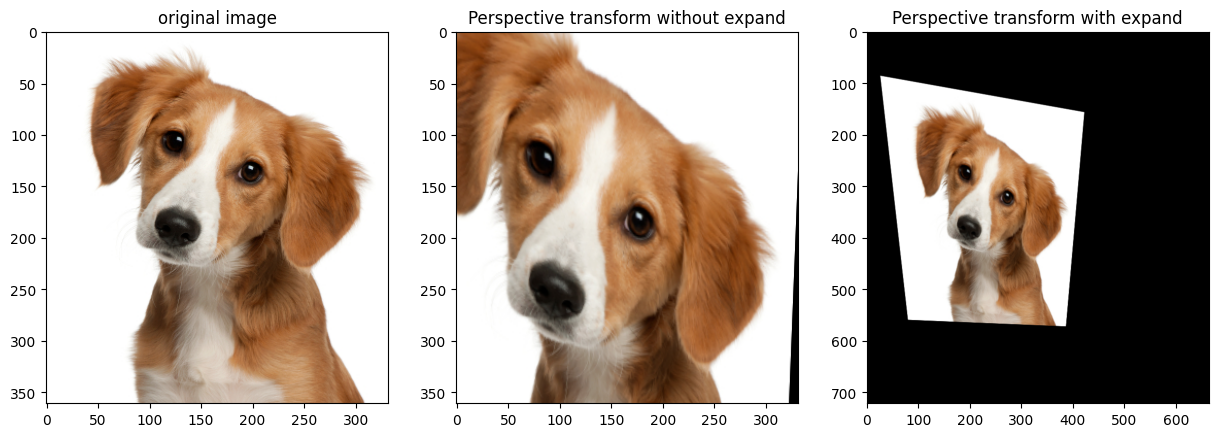

In [60]:
plt.figure(figsize=(15, 8))
plt.subplot(131)
plt.title("original image")
plt.imshow(image.permute(1, 2, 0))
plt.subplot(132)
plt.title("Perspective transform without expand")
plt.imshow(output.permute(1, 2, 0))
plt.subplot(133)
plt.title("Perspective transform with expand")
plt.imshow(output2.permute(1, 2, 0))

In [1]:
import os

import torch

# from torch.nn.functional import grid_sample, affine_grid
from torch._decomp.decompositions import Tensor, TensorSequenceType, _sum_tensors, _upsample_cubic_interp1d

torch.set_printoptions(precision=7)


In [2]:
def _linspace_from_neg_one(
    num_steps: int, align_corners: bool, dtype: torch.dtype, device: torch.device
):
    if num_steps <= 1:
        return torch.tensor(0, device=device, dtype=dtype)

    a = ((num_steps - 1) / num_steps) if not align_corners else 1
    return torch.linspace(-a, a, steps=num_steps, device=device, dtype=dtype)


def _grid_sampler_2d(
    a: Tensor,
    grid: Tensor,
    interpolation_mode: int = 0,
    padding_mode: int = 0,
    align_corners: bool = False,
) -> Tensor:
    torch._check(
        interpolation_mode in (0, 1, 2),
        lambda: f"Invalid interpolation mode {interpolation_mode}",
    )
    torch._check(
        padding_mode in (0, 1, 2), lambda: f"Invalid padding mode {padding_mode}"
    )

    def unnormalize(coords: Tensor, size: int) -> Tensor:
        # Rescale coordinates from [-1, 1] to:
        #   [0, size - 1] if align_corners is True
        #   [-.5, size -.5] if align_corners is False
        mul = (size * 0.5 - 0.5) if align_corners else (size * 0.5)
        ofs = size * 0.5 - 0.5
        return coords * mul + ofs

    # Reflects coordinates until they fall between low and high (inclusive).
    # The bounds are passed as twice their value so that half-integer values
    # can be represented as ints.
    def reflect_coordinates(coords: Tensor, twice_low: int, twice_high: int) -> Tensor:
        if twice_low == twice_high:
            return torch.zeros_like(coords)
        coords_min = twice_low / 2
        coords_span = (twice_high - twice_low) / 2
        coords2 = (coords - coords_min).abs()
        extra = torch.fmod(coords2, coords_span)
        flips = (coords2 / coords_span).floor().to(dtype=torch.int8)
        return torch.where(
            flips & 1 == 0, extra + coords_min, coords_span + coords_min - extra
        )

    def compute_coordinates(coords: Tensor, size: int) -> Tensor:
        if padding_mode == 0:  # Zero
            return coords
        elif padding_mode == 1:  # Borders
            return torch.clamp(coords, 0, size - 1)
        else:  # padding_mode == 2, Reflection
            if align_corners:
                coords_reflected = reflect_coordinates(coords, 0, 2 * (size - 1))
            else:
                coords_reflected = reflect_coordinates(coords, -1, 2 * size - 1)
            return torch.clamp(coords_reflected, 0, size - 1)

    def compute_source_index(coords: Tensor, size: int) -> Tensor:
        coords_un = unnormalize(coords, size)
        return compute_coordinates(coords_un, size)

    N, C, iH, iW = a.shape
    N, C, oH, oW, _ = grid.shape

    def in_bounds_cond(xs: Tensor, ys: Tensor) -> Tensor:
        return torch.logical_and(
            0 <= xs, torch.logical_and(xs < iW, torch.logical_and(0 <= ys, ys < iH))
        )

    N_idx = torch.arange(N, device=a.device).view(N, 1, 1, 1)
    C_idx = torch.arange(C, device=a.device).view(1, C, 1, 1)

    def clip(xs: Tensor, ys: Tensor, ws: Tensor) -> TensorSequenceType:
        cond = in_bounds_cond(xs, ys)
        # To clip to inside valid coordinates, we map the coordinates
        # to (x, y) = (0, 0) and also set the weight to 0
        # We also change the shape of the tensor to the appropriate one for
        # broadcasting with N_idx, C_idx for the purposes of advanced indexing
        return tuple(
            torch.where(cond, t, 0).view(N, C, oH, oW)
            for t in (xs.to(dtype=torch.int64), ys.to(dtype=torch.int64), ws)
        )

    def get_summand(ix: Tensor, iy: Tensor, w) -> Tensor:
        # Perform clipping, index into input tensor and multiply by weight
        idx_x, idx_y, w_ = clip(ix, iy, w)
        return a[N_idx, C_idx, idx_y, idx_x] * w_

    x = grid[..., 0]
    y = grid[..., 1]

    if interpolation_mode == 0:  # Bilinear
        ix = compute_source_index(x, iW)
        iy = compute_source_index(y, iH)

        ix_nw, iy_nw = ix.floor(), iy.floor()
        ix_ne, iy_ne = ix_nw + 1, iy_nw
        ix_sw, iy_sw = ix_nw, iy_nw + 1
        ix_se, iy_se = ix_ne, iy_sw

        w_nw = (ix_se - ix) * (iy_se - iy)
        w_ne = (ix - ix_sw) * (iy_sw - iy)
        w_sw = (ix_ne - ix) * (iy - iy_ne)
        w_se = (ix - ix_nw) * (iy - iy_nw)

        return _sum_tensors(
            get_summand(ix, iy, w)
            for (ix, iy, w) in (
                (ix_nw, iy_nw, w_nw),
                (ix_ne, iy_ne, w_ne),
                (ix_sw, iy_sw, w_sw),
                (ix_se, iy_se, w_se),
            )
        )
    elif interpolation_mode == 1:  # Nearest
        ix = compute_source_index(x, iW)
        iy = compute_source_index(y, iH)

        ix_nearest = ix.round()
        iy_nearest = iy.round()

        return get_summand(ix_nearest, iy_nearest, 1)
    else:  # interpolation_mode == 2, Bicubic
        ix = unnormalize(x, iW)
        iy = unnormalize(y, iH)

        ix_nw = ix.floor()
        iy_nw = iy.floor()

        tx = ix - ix_nw
        ty = iy - iy_nw

        def get_value_bounded(ix: Tensor, iy: Tensor) -> Tensor:
            x = compute_coordinates(ix, iW)
            y = compute_coordinates(iy, iH)
            return get_summand(x, y, 1)

        def get_coeff(ofs: int) -> Tensor:
            iy_ofs = iy_nw + (ofs - 1)
            cs = (
                get_value_bounded(ix_nw - 1, iy_ofs),
                get_value_bounded(ix_nw, iy_ofs),
                get_value_bounded(ix_nw + 1, iy_ofs),
                get_value_bounded(ix_nw + 2, iy_ofs),
            )
            return _upsample_cubic_interp1d(cs, tx)

        coeffs = tuple(get_coeff(ofs) for ofs in range(4))
        return _upsample_cubic_interp1d(coeffs, ty)


In [3]:
a = torch.deg2rad(torch.tensor(45.0))
s1 = 1.23
s2 = 1.34
ca, sa = torch.cos(a), torch.sin(a)

# device = "cpu"
device = "cuda"

torch.manual_seed(12)
num_threads = 1
torch.set_num_threads(num_threads)

memory_format = torch.contiguous_format
# memory_format = torch.channels_last
# dtype = torch.float64
dtype = torch.float32

align_corners = False
# mode = "nearest"
# mode = "bicubic"
# mode = "bilinear"
mode = 0

n = 8

c, h, w = 3, 345, 456
theta = torch.tensor([[
    [ca / s1, sa, 0.0],
    [-sa, ca / s2, 0.0],
]])
theta = theta.expand(n, 2, 3).contiguous()
x = torch.arange(n * c * h * w, device=device).reshape(n, c, h, w).to(torch.uint8)
theta = theta.to(device=device, dtype=dtype)

In [4]:
img = x

n, c, h, w = img.shape

In [11]:
dtype = theta.dtype
device = theta.device

# Using padding and summation generates a single kernel vs using torch.stack where 3 kernels generated
# corresponding to each individual tensor: grid_x, grid_y, grid_one
grid_x = _linspace_from_neg_one(w, align_corners, dtype, device).view(1, w, 1)
grid_y = _linspace_from_neg_one(h, align_corners, dtype, device).view(h, 1, 1)
grid_one = torch.ones((1, 1, 1), dtype=dtype, device=device)

# this is just a temporary hack and we should use torch.stack here once #104480 is merged
grid_x = torch.nn.functional.pad(grid_x, pad=(0, 2), mode="constant", value=0)
grid_y = torch.nn.functional.pad(grid_y, pad=(1, 1), mode="constant", value=0)
grid_one = torch.nn.functional.pad(grid_one, pad=(2, 0), mode="constant", value=0)
base_grid =  grid_x + grid_y + grid_one
base_grid.shape

torch.Size([345, 456, 3])

In [12]:
base_grid = base_grid.view(1, 1, h, w, 3).expand(n, c, h, w, 3)
base_grid.shape

torch.Size([8, 3, 345, 456, 3])

In [ ]:
# base_grid shape is (n, c, h, w, 3) and theta shape is (n, 2, 3)
# We do manually a matrix multiplication which is faster than mm()
# (n, c, h * w, 3, 1) * (n, 1, 1, 3, 2) -> (n, c, h * w, 2)


In [18]:
base_grid.view(n, c, -1, 3, 1).shape

torch.Size([8, 3, 157320, 3, 1])

In [20]:
theta.shape, theta.mT.unsqueeze(1).shape

(torch.Size([8, 2, 3]), torch.Size([8, 1, 3, 2]))

In [16]:
base_grid.view(n, c, -1, 3, 1).shape

torch.Size([8, 3, 157320, 3, 1])

In [22]:
grid = (base_grid.view(n, c, -1, 3, 1) * theta.mT.view(n, 1, 1, 3, 2)).sum(-2)
grid = grid.view(n, c, h, w, 2)
grid.shape

torch.Size([8, 3, 345, 456, 2])

In [23]:
output = _grid_sampler_2d(img, grid, align_corners=align_corners, interpolation_mode=mode)

In [24]:
output.shape

torch.Size([8, 3, 345, 456])

In [ ]:




def transform(img, theta, align_corners, mode):


    # grid = affine_grid(theta, size=(n, c, h, w), align_corners=align_corners)
    base_grid = base_grid.view(1, 1, h, w, 2).expand(n, c, h, w, 2)

    grid = (base_grid.view(-1, 3, 1) * theta.mT.unsqueeze(1)).sum(-2)
    grid = grid.view(n, c, h, w, 2)

    output = _grid_sampler_2d(img, grid, align_corners=align_corners, interpolation_mode=mode)
    return output




    x = x.to(dtype=dtype)
    x = x.contiguous(memory_format=memory_format)

    output = c_transform(x, theta, align_corners, mode)
    expected = transform(x, theta, align_corners, mode)

In [30]:
ws = 1
r = 0

In [34]:
y = list(range(1, 9))
y

[1, 2, 3, 4, 5, 6, 7, 8]

In [35]:
def cond(j):
    return (ws * j + r) % 3 == 0

In [36]:
y_pred = [
    v if cond(j) else 0
    for j, v in enumerate(y)
]
y_pred

[1, 0, 0, 4, 0, 0, 7, 0]

In [40]:
ws = 2
r = 0

In [41]:
y = list(range(1, 9))[r::ws]
y

[1, 3, 5, 7]

In [42]:
def cond(j):
    return (ws * j + r) % 3 == 0

In [43]:
y_pred = [
    v if cond(j) else 0
    for j, v in enumerate(y)
]
y_pred

[1, 0, 0, 7]

In [44]:
r = 1

In [45]:
y = list(range(1, 9))[r::ws]
y

[2, 4, 6, 8]

In [46]:
def cond(j):
    return (ws * j + r) % 3 == 0

In [47]:
y_pred = [
    v if cond(j) else 0
    for j, v in enumerate(y)
]
y_pred

[0, 4, 0, 0]

In [59]:
from PIL import Image

input = Image.open("../dog.jpg")

kwargs = dict(angle=45, expand=True)

# output_w_center = F.rotate(input, **kwargs, center=(1.2, 4.9))
# output_wo_center = F.rotate(input, **kwargs, center=None)

output_w_center = input.rotate(angle=45, expand=True, center=(0, 0))
output_wo_center = input.rotate(angle=45, expand=True, center=None)

# shape_w_center = F.get_image_size(output_w_center)
# shape_wo_center = F.get_image_size(output_wo_center)
# assert shape_w_center == shape_wo_center, f"{shape_w_center} != {shape_wo_center}"

assert output_w_center.size == output_wo_center.size, (output_w_center.size, output_wo_center.size)


AssertionError: ((491, 491), (492, 491))

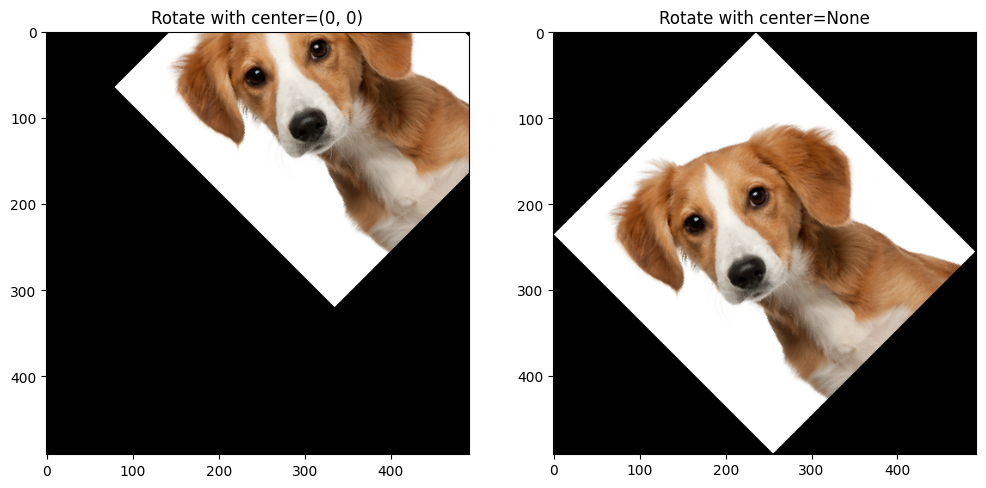

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title(f"Rotate with center=(0, 0)")
plt.imshow(output_w_center)
plt.subplot(122)
plt.title(f"Rotate with center=None")
plt.imshow(output_wo_center)


In [64]:
from PIL import Image
input = Image.open("../dog.jpg")
output_w_center = input.rotate(angle=89, expand=True, center=(0, 0))
output_wo_center = input.rotate(angle=89, expand=True, center=None)

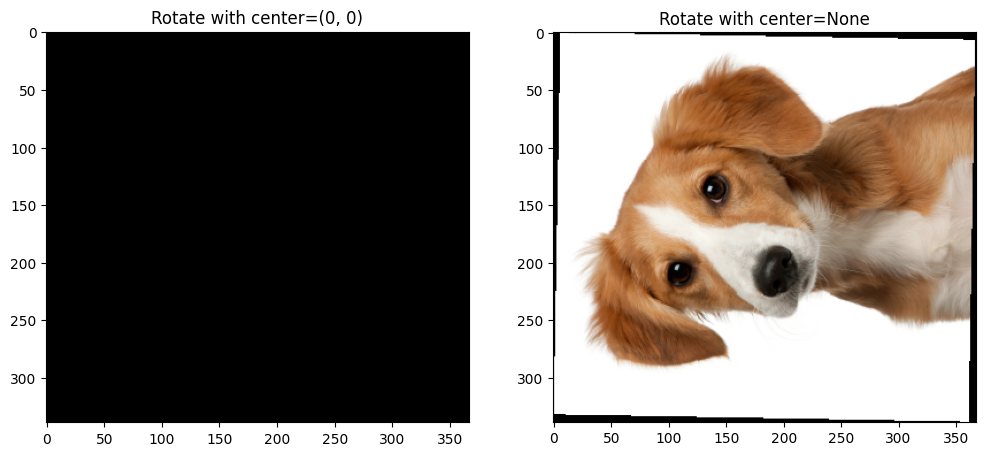

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title(f"Rotate with center=(0, 0)")
plt.imshow(output_w_center)
plt.subplot(122)
plt.title(f"Rotate with center=None")
plt.imshow(output_wo_center)


In [66]:
from PIL import Image
input = Image.open("../dog.jpg")
output_w_center = input.rotate(angle=90, expand=True, center=(0, 0))
output_wo_center = input.rotate(angle=90, expand=True, center=None)

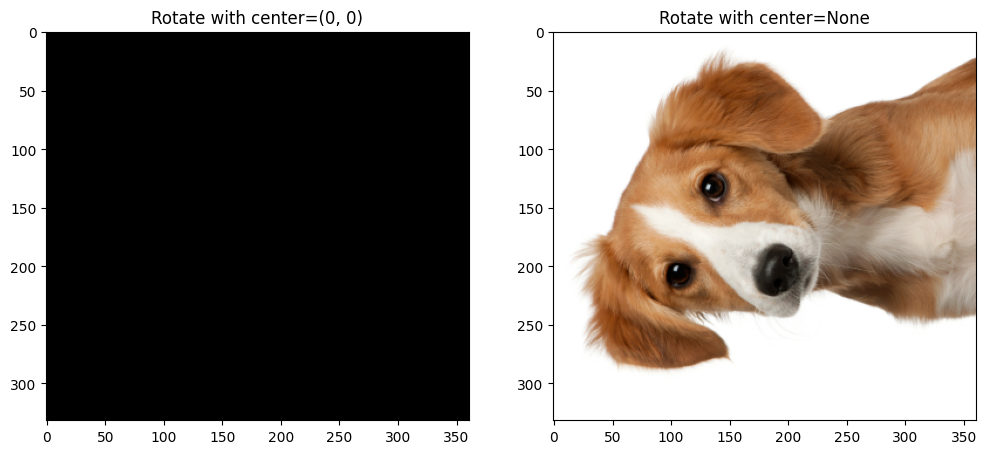

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title(f"Rotate with center=(0, 0)")
plt.imshow(output_w_center)
plt.subplot(122)
plt.title(f"Rotate with center=None")
plt.imshow(output_wo_center)
